In [ ]:
# # !pip install transformers
!pip install simpletransformers

     |████████████████████████████████| 249 kB 5.3 MB/s 
     |████████████████████████████████| 10.1 MB 24.5 MB/s 
     |████████████████████████████████| 325 kB 40.5 MB/s 
     |████████████████████████████████| 1.8 MB 32.6 MB/s 
     |████████████████████████████████| 1.2 MB 36.1 MB/s 
     |████████████████████████████████| 6.6 MB 15.1 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 4.0 MB 24.6 MB/s 
     |████████████████████████████████| 596 kB 36.6 MB/s 
     |████████████████████████████████| 895 kB 17.1 MB/s 
     |████████████████████████████████| 77 kB 4.6 MB/s 
     |████████████████████████████████| 181 kB 39.3 MB/s 
     |████████████████████████████████| 144 kB 34.0 MB/s 
     |████████████████████████████████| 63 kB 991 kB/s 
     |████████████████████████████████| 212 kB 53.0 MB/s 
     |████████████████████████████████| 1.1 MB 40.8 MB/s 
     |████████████████████████████████| 136 kB 52.6 MB/s 
     |██████████████

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import torchtext
import torch
from torch import nn
# import json, re, unicodedata, string, typing, time
import torch.nn.functional as F
import spacy
from collections import Counter
import pickle
from nltk import word_tokenize
nlp = spacy.load('en')
os.chdir("/content/drive/MyDrive/Data2")
from torch import Tensor, nn, optim
from tqdm import tqdm
from simpletransformers.language_representation import RepresentationModel

In [ ]:
train_data = pd.read_json("train.jsonl",lines = True)
print(train_data.shape[0])
val_data = pd.read_json("dev.jsonl",lines = True)
test_data = pd.read_json("test.jsonl",lines = True)
# train_data.head(), train_data.head()

9427


In [ ]:
val_data.shape,test_data.shape,train_data.shape

In [ ]:
train_data = train_data.iloc[:4000]
train_data.shape

(4000, 4)

In [ ]:
import logging
logging.disable(logging.WARNING) 

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
model = RepresentationModel(
        model_type='bert',
        model_name = 'bert-base-uncased',
        use_cuda=True
)
combined_passage = train_data['passage']
combined_question = train_data['question']
# combined_val = val_data[['passage','question']]
# combined_test = test_data[['passage','question']]
batch_embeddings_passage = []
batch_embeddings_question = []
batch_embeddings_val = []
batch_embeddings_test = []
for combi in combined_passage:
    batch_embeddings_passage.append(combi)
for combi in combined_question:
    batch_embeddings_question.append(combi)
    # print(batch_embeddings)

embeddings_pass = model.encode_sentences( batch_embeddings_passage, batch_size=1000, combine_strategy=None)
embeddings_question = model.encode_sentences( batch_embeddings_question, batch_size=4000, combine_strategy=None)
embeddings_pass = torch.as_tensor(embeddings_pass)
embeddings_question = torch.as_tensor(embeddings_question)

In [ ]:
# embeddings_question.shape

torch.Size([4000, 24, 768])

In [ ]:
# embeddings_ques_pt1 = embeddings_question[:3000]
# embeddings_ques_pt2 = embeddings_question[3000:]

In [ ]:
# with open("train_question_only_embeddings_bert.pkl","wb") as fl:
#   pickle.dump(embeddings_question,fl)

In [ ]:
# with open("train_passage_only_embeddings_bert_pt1.pkl","rb") as fl:
#   embpickle.load(fl)

In [ ]:
# with open("val_embeddings_bert.pkl","wb") as fl:
#   pickle.dump(embeddings_val,fl)

In [ ]:
class QATransformer(nn.Module):
    def __init__(
        self,
        num_encoder_layers: int = 2,
        dim_model: int = 768,
        num_heads: int = 6,
        dim_feedforward: int = 2100,
        dropout: float = 0.,
        amalgamated_dim = 300,
    ):
        super().__init__()
        
        self.encoder_question = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=dim_model, 
                                                                                nhead=num_heads, 
                                                                                dim_feedforward=dim_feedforward, 
                                                                                dropout=dropout), 
                                                                                num_layers = num_encoder_layers)
        self.encoder_context = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=dim_model, 
                                                                                nhead=num_heads, 
                                                                                dim_feedforward=dim_feedforward, 
                                                                                dropout=dropout), 
                                                                                num_layers = num_encoder_layers)
        self.encoder_amalgamated = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=dim_model, 
                                                                        nhead=num_heads, 
                                                                        dim_feedforward=dim_feedforward, 
                                                                        dropout=dropout), 
                                                                        num_layers = num_encoder_layers)
        self.amalgmated_linear_2 = nn.Linear(dim_model, dim_feedforward)
        # self.attention = nn.MultiheadAttention(embed_dim= dim_feedforward,
        #                                        num_heads = num_heads,
        #                                        dropout=dropout,
        #                                        batch_first=True)

        self.linear_1 = nn.Linear(dim_feedforward, dim_feedforward)
        self.linear_2 = nn.Linear(amalgamated_dim*dim_feedforward, 1)

    def forward(self, context: Tensor, question: Tensor) -> Tensor:
        # print(context.type(), question.type())
        # src = torch.hstack([context,  question])
        question = self.encoder_question(question)
        context = self.encoder_context(context)

        amalgamated_x = torch.hstack([context, question])
        amalgamated_x = self.encoder_amalgamated(amalgamated_x)
        # print(amalgamated_x.shape)
        amalgamated_x = torch.relu(self.amalgmated_linear_2(amalgamated_x))
        # print(amalgamated_x.shape,
              # amalgamated_attention.shape)
        # amalgamated_x, att = self.attention(amalgamated_x,amalgamated_x,amalgamated_x)
        amalgamated_x = torch.relu(self.linear_1(amalgamated_x))
        amalgamated_x = amalgamated_x.flatten(1)
        amalgamated_x = self.linear_2(amalgamated_x)
        return torch.sigmoid(amalgamated_x).squeeze()

In [ ]:
with open("train_passage_only_embeddings_bert_pt1.pkl","rb") as fl:
  embeddings_1 = pickle.load(fl)
with open("train_passage_only_embeddings_bert_pt2.pkl","rb") as fl:
  embeddings_2 = pickle.load(fl)
embeddings_passage = torch.vstack((embeddings_1,embeddings_2))
with open("train_question_only_embeddings_bert.pkl","rb") as fl:
  embeddings_question = pickle.load(fl)
embeddings_passage = embeddings_passage[:4000]
# with open("val_embeddings_bert.pkl","rb") as fl:
#   embeddings = pickle.load(fl)

In [ ]:
np.random.seed(91)
ind = np.random.permutation(np.arange(4000),)
train_ind = ind[:(4000-512)]
test_ind = ind[-512:-256]
val_ind = ind[-256:]

In [ ]:
test_embeddings_pass = embeddings_passage[test_ind.tolist()]
test_embeddings_ques = embeddings_question[test_ind.tolist()]
val_embeddings_pass = embeddings_passage[val_ind.tolist()]
val_embeddings_ques = embeddings_question[val_ind.tolist()]
embeddings_passage = embeddings_passage[train_ind.tolist()]
embeddings_question = embeddings_question[train_ind.tolist()]

In [ ]:
if torch.cuda.is_available():
  embeddings_question = embeddings_question.to('cuda')
  embeddings_passage = embeddings_passage.to('cuda')
  val_embeddings_pass = val_embeddings_pass.to('cuda')
  val_embeddings_ques = val_embeddings_ques.to('cuda')
  # test_embeddings = test_embeddings.to('cuda')

In [ ]:
val_embeddings_ques.shape,val_embeddings_pass.shape,embeddings_question.shape,embeddings_passage.shape

(torch.Size([256, 24, 768]),
 torch.Size([256, 128, 768]),
 torch.Size([3488, 24, 768]),
 torch.Size([3488, 128, 768]))

In [ ]:
train_data.shape

(4000, 4)

In [ ]:
test_data = train_data.iloc[test_ind]
# val_data = train_data.iloc[2716:2816]
val_data=  train_data.iloc[val_ind]
train_data = train_data.iloc[train_ind]
train_data.shape,val_data.shape,test_data.shape

((3488, 4), (256, 4), (256, 4))

# Train model

In [ ]:
from torch import nn,optim,Tensor
net = QATransformer(amalgamated_dim = 152)
if torch.cuda.is_available():
    net = net.to("cuda")
optimizer = optim.Adam(net.parameters(), lr=1e-5, weight_decay = 1e-6)
criterion = nn.BCELoss()
criterion_val = nn.BCELoss()
# label_val = torch.as_tensor(val_data['answer'].tolist()).float()
# label_val = torch.as_tensor(val_data['answer'].tolist()).float()
if torch.cuda.is_available():
    criterion = criterion.to("cuda")
    # label_val.to('cuda')
loss_array = []
acc = []
acc_val = []
epochs=20
batch_size=32
loss_val_array =[]
for epoch in tqdm(range(epochs)):
    running_loss = 0
    encodings_arr = []
    for index in range(embeddings_question.shape[0]//batch_size):
        idx_start = index*batch_size
        idx_end = (index+1)*batch_size
        optimizer.zero_grad()
        emb_q = embeddings_question[idx_start:idx_end]
        emb_p = embeddings_passage[idx_start:idx_end]
        label = torch.as_tensor(train_data.iloc[idx_start:idx_end]['answer'].tolist()).float()
        if torch.cuda.is_available():
            label = label.to("cuda")
        output = net(emb_p,emb_q)
        # output = net(emb_q)
        loss = criterion(output,label)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()*batch_size
    loss_array.append(running_loss/train_data.shape[0])
    # loss_array.append(running_loss/train_data.shape[0])
    pred = []
    pred_val = []
    for index in range(embeddings_question.shape[0]//batch_size):
        idx_start = index*batch_size
        idx_end = (index+1)*batch_size
        out = net(embeddings_passage[idx_start:idx_end],embeddings_question[idx_start:idx_end])
        # out_val = net(val_embeddings)
        label = torch.as_tensor(train_data.iloc[idx_start:idx_end]['answer'].tolist()).float()
        if torch.cuda.is_available():
            label = label.to("cuda")
        pred.extend((torch.round(out) > 0.5).int() == label)
        # pred_val.extend((torch.round(out_val) > 0.5).int() == label_val)
    running_loss_val = 0
    
    for index in range(val_embeddings_pass.shape[0]//batch_size):
        idx_start = index*batch_size
        idx_end = (index+1)*batch_size
        # out = net(embeddings[idx_start:idx_end])
        out_val = net(val_embeddings_pass[idx_start:idx_end],val_embeddings_ques[idx_start:idx_end])
        label = torch.as_tensor(val_data.iloc[idx_start:idx_end]['answer'].tolist()).float()
        if torch.cuda.is_available():
            label = label.to("cuda")
        loss_val = criterion_val(out_val,label)
        running_loss_val +=loss_val.item()*batch_size
        pred_val.extend((torch.round(out_val) > 0.5).int() == label)
    loss_val_array.append(running_loss_val/val_data.shape[0])

    pred = torch.as_tensor(pred)
    pred_val = torch.as_tensor(pred_val)
    curr_acc = pred.sum()/pred.shape[0]
    curr_acc_val = pred_val.sum()/pred_val.shape[0]
    acc.append(curr_acc)
    acc_val.append(curr_acc_val)
    print(loss_array[-1], acc[-1], acc_val[-1],loss_val_array[-1])

    # if len(acc_val)>=2 and acc_val[-1] < acc_val[-2]:
    #   break

  5%|▌         | 1/20 [01:12<22:50, 72.13s/it]

0.6675288912353166 tensor(0.6230) tensor(0.6250) 0.6514891609549522


 10%|█         | 2/20 [02:24<21:42, 72.35s/it]

0.6315576177124583 tensor(0.6649) tensor(0.6406) 0.6416947096586227


 15%|█▌        | 3/20 [03:37<20:33, 72.56s/it]

0.5906045207189857 tensor(0.7377) tensor(0.6602) 0.6297694444656372


 20%|██        | 4/20 [04:50<19:23, 72.69s/it]

0.5373910405767073 tensor(0.7893) tensor(0.6484) 0.622305054217577


 25%|██▌       | 5/20 [06:03<18:10, 72.72s/it]

0.47899472002589377 tensor(0.8455) tensor(0.6836) 0.6211465373635292


 30%|███       | 6/20 [07:15<16:57, 72.71s/it]

0.41763565627806776 tensor(0.8739) tensor(0.6875) 0.6299205645918846


 35%|███▌      | 7/20 [08:28<15:45, 72.71s/it]

0.35829215585638624 tensor(0.9037) tensor(0.6914) 0.6453343294560909


 40%|████      | 8/20 [09:41<14:32, 72.70s/it]

0.3018862491627352 tensor(0.9183) tensor(0.6875) 0.6712846346199512


 45%|████▌     | 9/20 [10:53<13:19, 72.68s/it]

0.24963042782534153 tensor(0.9246) tensor(0.6836) 0.7090650796890259


 50%|█████     | 10/20 [12:06<12:06, 72.67s/it]

0.2052356293852176 tensor(0.9154) tensor(0.6719) 0.7742038331925869


 55%|█████▌    | 11/20 [13:19<10:53, 72.66s/it]

0.20172060697997382 tensor(0.9450) tensor(0.5898) 0.7260224781930447


 60%|██████    | 12/20 [14:31<09:41, 72.63s/it]

0.2964031540472573 tensor(0.9647) tensor(0.6641) 0.6880289129912853


 65%|██████▌   | 13/20 [15:44<08:28, 72.62s/it]

0.207465488771233 tensor(0.9877) tensor(0.6367) 0.689158096909523


 70%|███████   | 14/20 [16:56<07:15, 72.62s/it]

0.15975396123227723 tensor(0.9894) tensor(0.6133) 0.7123205624520779


 75%|███████▌  | 15/20 [18:09<06:03, 72.61s/it]

0.12477326584518503 tensor(0.9931) tensor(0.6133) 0.7265952229499817


 80%|████████  | 16/20 [19:22<04:50, 72.61s/it]

0.10328558183044469 tensor(0.9931) tensor(0.6211) 0.7606630250811577


 85%|████████▌ | 17/20 [20:34<03:37, 72.59s/it]

0.08864930131976757 tensor(0.9633) tensor(0.6602) 0.9524355158209801


 90%|█████████ | 18/20 [21:47<02:25, 72.61s/it]

0.07760613480018913 tensor(0.8799) tensor(0.6406) 1.2513183504343033


 95%|█████████▌| 19/20 [23:00<01:12, 72.74s/it]

0.07799007863216444 tensor(0.9332) tensor(0.6445) 1.1325285211205482


100%|██████████| 20/20 [24:13<00:00, 72.67s/it]

0.08764129212348286 tensor(0.9627) tensor(0.6445) 1.0483633801341057


In [ ]:
# with open("bert_on_gqat_seed_91.pkl",'wb') as fl:
#     pickle.dump(net,fl)

In [ ]:
with open("bert_on_gqat.pkl",'rb') as fl:
  net = pickle.load(fl)

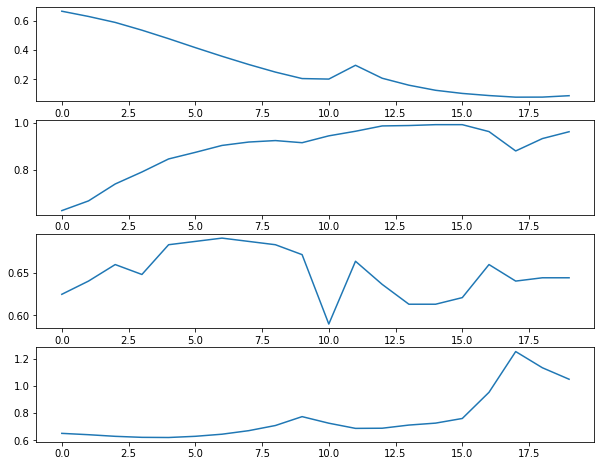

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,8))

plt.subplot(4,1,1)
plt.plot(loss_array)

plt.subplot(4,1,2)
plt.plot(acc)

plt.subplot(4,1,3)
plt.plot(acc_val)
plt.subplot(4,1,4)
plt.plot(np.array(loss_val_array))
plt.show()

In [ ]:
with open("final_model_bert_on_gqat_3488_train_loss_array.pkl","wb") as fl:
  pickle.dump(loss_array,fl)
with open("final_model_bert_on_gqat_3488_train_accuracy_array.pkl","wb") as fl:
  pickle.dump(acc,fl)
with open("final_model_bert_on_gqat_3488_val_loss_array.pkl","wb") as fl:
  pickle.dump(loss_val_array,fl)
with open("final_model_bert_on_gqat_3488_val_accuracy_array.pkl","wb") as fl:
  pickle.dump(acc_val,fl)

In [ ]:
# with open("final_model_5488_train_1.pkl","wb") as fl:
#   pickle.dump(net,fl)

# Load saved model

In [ ]:
# with open("final_model_5488_train_1.pkl","rb") as fl:
#   net = pickle.load(fl)

In [ ]:
torch.no_grad()
torch.cuda.empty_cache()

# Test accuracy

In [ ]:
# net.to('cuda')
# # temb_cpu = test_embeddings.to("cpu")
test_data

## test on whole test data

In [ ]:
if torch.cuda.is_available():
    test_embeddings_pass = test_embeddings_pass.to('cuda')
    test_embeddings_ques = test_embeddings_ques.to('cuda')
pred = net(test_embeddings_pass,test_embeddings_ques)
x = (pred>= 0.5).int()
label = torch.as_tensor(test_data['answer'].tolist()).int().to('cuda')
acc = (x == label).sum() / label.shape[0]
acc

tensor(0.7617, device='cuda:0')

In [ ]:
label = label.to('cpu')
x = x.to('cpu')

In [ ]:
label = np.array(label)
x = np.array(x)

## F1 Score

In [ ]:
from sklearn.metrics import f1_score
f1_score(label,x)

0.8319559228650137